# Simulation 2: Gaussian Mixture 
This is code to support simulations in the paper "Log-concave sampling: Metropolis-Hastings algorithms are fast!"

by Raaz Dwivedi, Yuansi Chen, Martin J. Wainwright, Bin Yu

In [69]:
# load necessary packages
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# load our packages
import mcmc
import plot_basic # basic setting for plots in matplotlib

### Density of the Gaussian Mixture
$a$ is a parameter to be chosen.
$$
p(x) = \frac{1}{2 (2\pi)^{d/2}} (e^{-\|x-a\|^2/2}+e^{-\|x+a\|^2/2})
$$

$$
f(x) = \frac{1}{2} \|x-a\|^2 - \log(1 + e^{-2x^{\top}a})
$$

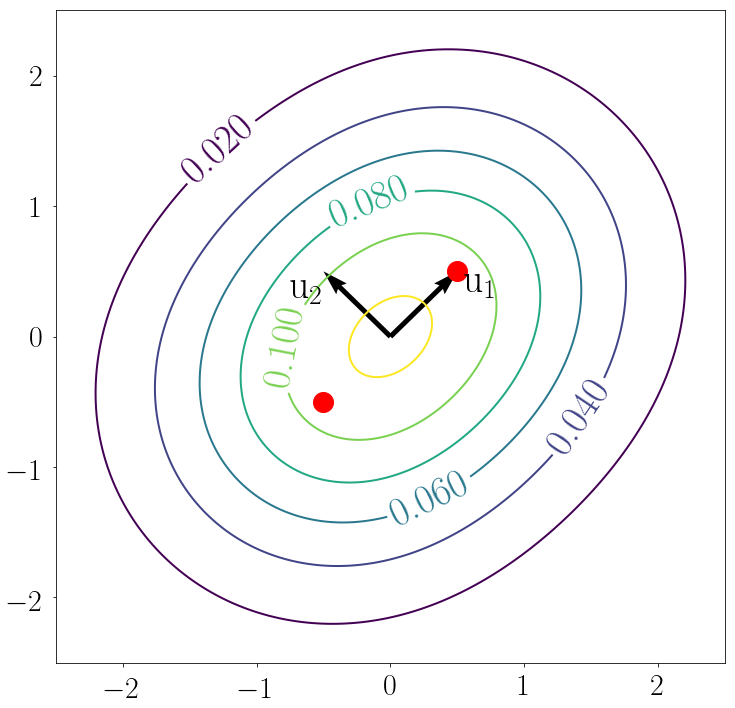

In [234]:
delta = 0.025
d = 2
x = np.arange(-2.5, 2.5, delta)
y = np.arange(-2.5, 2.5, delta)
a = np.ones(d)/np.sqrt(d)*np.sqrt(0.5)
X, Y = np.meshgrid(x, y)
Z1 = matplotlib.mlab.bivariate_normal(X, Y, 1.0, 1.0, a[0], a[1])
Z2 = matplotlib.mlab.bivariate_normal(X, Y, 1.0, 1.0, -a[0], -a[1])
# mixture of two Gaussians
Z = 0.5 * (Z2 +  Z1)

plt.figure(figsize=(12., 12.))
CS = plt.contour(X, Y, Z)

plt.clabel(CS, inline=1, fontsize=40)
plt.plot(a[0], a[1], 'ro', markersize=20)
plt.plot(-a[0], -a[1], 'ro', markersize=20)

soa = np.array([[0, 0, a[0], a[1]], [0, 0, -a[0], a[1]]])
X, Y, U, V = zip(*soa)
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)

plt.annotate('u_1', xy=(a[0], a[1]), xytext=(a[0]+0.05, a[1]-0.2), fontsize=40)
plt.annotate('u_2', xy=(-a[0], -a[1]), xytext=(-a[0]-0.25, a[1]-0.25),  fontsize=40)



plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
# save to the following path: modify before use
save_path = '/Users/yuansi.chen/UCB/STAT_2017/Writing/MALA/mala_code_public/mala_public/fig/'
plt.savefig(save_path+'gaussian_mixture.pdf')
plt.show()


In [13]:
# define the logconcave function: the two gaussian mixture
def f(x, a = 0.):
    # x is of dimension n * d
    return np.sum((x - a)**2/2, axis = 1) - np.log(1 + np.exp(-2*x.dot(a)))

# p(x): density of f up to a constant
def density_f(x, a=0.):
    return  np.exp(-f(x, a))

# gradient of f up to a constant
def grad_f(x, a = 0.):
    # x is of dimension n * d
    return (x - a) + 2 * np.outer(1./(1 + np.exp(2*x.dot(a))), a)

# sample f (nb_exps) times
def sample_f(nb_exps, d, a):
    coin = np.random.binomial(1, 0.5, nb_exps) * 2. - 1.
    return np.outer(coin, a) + np.random.randn(nb_exps, d)

# discrete total variation distance between two samples
def discrete_tv(x, y):
    return np.sum(np.abs(x-y))

In [14]:
np.random.seed(12345678)

# dimensions
ds = np.array([2])
# number of iterations, 600 will take several minutes, try with 100 first.
nb_iters = 600
# number of samples
nb_exps = 250000
# number of bins
nb_bins = 100

error_ula_all = np.zeros((ds.shape[0], nb_iters, 2))
error_ula_02_all = np.zeros((ds.shape[0], nb_iters, 2))
error_ula_002_all = np.zeros((ds.shape[0], nb_iters, 2))
error_mala_all = np.zeros((ds.shape[0], nb_iters, 2))
error_rwmh_all = np.zeros((ds.shape[0], nb_iters, 2))

error_lower_tv_max = np.zeros((ds.shape[0], 2))
error_lower_tv_min = np.ones((ds.shape[0], 2))*100

### Traceplot

In [168]:
np.random.seed(12345678)

ds = np.array([2])
nb_iters = 1000
nb_exps = 100

trace_ula_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_ula_02_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_ula_002_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_mala_all = np.zeros((ds.shape[0], nb_iters, nb_exps))
trace_rwmh_all = np.zeros((ds.shape[0], nb_iters, nb_exps))

In [169]:
for j, d in enumerate(ds):
    a = np.ones(d)/np.sqrt(d)*np.sqrt(0.5)
    L = 1.0
    m = 1.0 - np.sum(a**2)
    kappa = float(L)/m
    
    print("start simulation for traceplot: d = %d, m = %0.2f, L = %0.2f, kappa = %0.2f" %(d, m, L, kappa))

    # define the error_metric to be the first coordinate to extract samples
    def error_first_coordinate(x_curr):
        return x_curr[:, 0]
    

    # initialization
    init_distr = 1./np.sqrt(0.01)*np.random.randn(nb_exps, d)
        

    def grad_f_local(x):
        return grad_f(x, a=a)

    def f_local(x):
        return density_f(x, a=a)

    trace_ula_all[j], x_ula = mcmc.ula(init_distr, grad_f_local, error_first_coordinate, epsilon=1.0, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_ula_02_all[j], x_ula_02 = mcmc.ula(init_distr, grad_f_local, error_first_coordinate, epsilon=0.2, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_ula_002_all[j], x_ula_002 = mcmc.ula(init_distr, grad_f_local, error_first_coordinate, epsilon=0.1, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_mala_all[j], x_mala = mcmc.mala(init_distr, grad_f_local, f_local, error_first_coordinate, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    trace_rwmh_all[j], x_rwmh = mcmc.rwmh(init_distr, f_local, error_first_coordinate, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

start simulation for traceplot: d = 2, m = 0.50, L = 1.00, kappa = 2.00


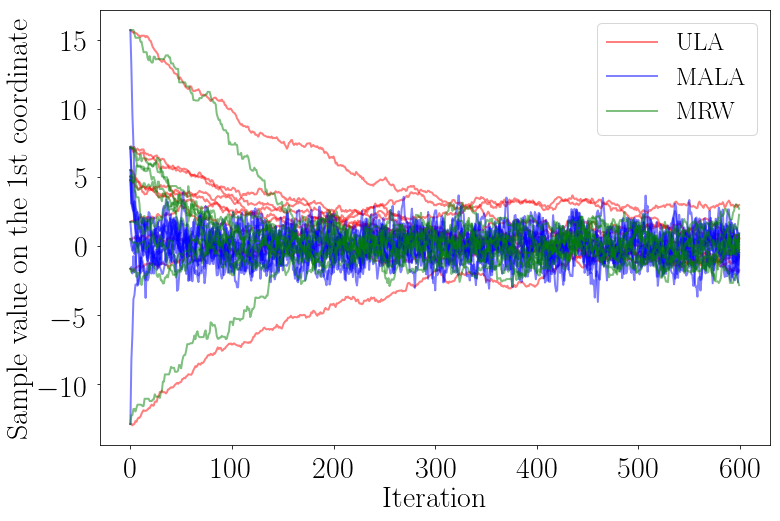

In [239]:
# traceplot
plt.figure(figsize=(12., 8.))
nb_plot_iters = 600
for i in range(10):
    if i == 0:
        plt.plot(trace_ula_02_all[0, :nb_plot_iters, i], color='r', alpha = 0.5, label='ULA')
    else:
        plt.plot(trace_ula_02_all[0, :nb_plot_iters, i], color='r', alpha = 0.5)
for i in range(10):
    if i == 0:
        plt.plot(trace_mala_all[0, :nb_plot_iters, i], color='b', alpha = 0.5, label='MALA')
    else:
        plt.plot(trace_mala_all[0, :nb_plot_iters, i], color='b', alpha = 0.5)
for i in range(10):
    if i == 0:
        plt.plot(trace_rwmh_all[0, :nb_plot_iters, i], color='g', alpha = 0.5, label='MRW')
    else:
        plt.plot(trace_rwmh_all[0, :nb_plot_iters, i], color='g', alpha = 0.5)

plt.xlabel("Iteration")
plt.ylabel("Sample value on the 1st coordinate")

plt.legend()

plt.savefig(save_path+'traceplot_gaussian_mixture_all.pdf')
plt.show()

### Autocorrelation plot

In [218]:
nb_lags = 600
nb_burnin = 250
autocorr_ula_02 = np.ones(nb_lags)
autocorr_mala = np.ones(nb_lags)
autocorr_rwmh = np.ones(nb_lags)

ith_run = 2

for i in range(1, nb_lags):
    autocorr_ula_02[i] = np.corrcoef(trace_ula_02_all[0, nb_burnin+i:, ith_run], trace_ula_02_all[0, nb_burnin:-i, ith_run])[0, 1]
    autocorr_mala[i] = np.corrcoef(trace_mala_all[0, nb_burnin+i:, ith_run], trace_mala_all[0, nb_burnin:-i, ith_run])[0, 1]
    autocorr_rwmh[i] = np.corrcoef(trace_rwmh_all[0, nb_burnin+i:, ith_run], trace_rwmh_all[0, nb_burnin:-i, ith_run])[0, 1]

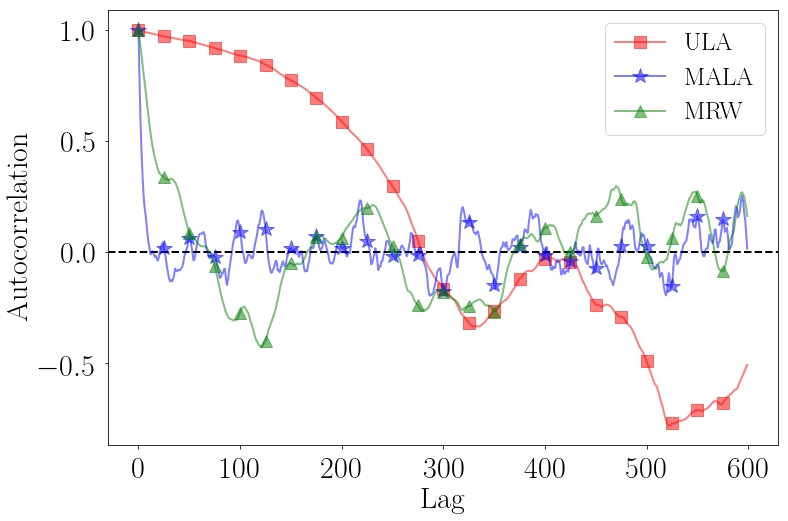

In [316]:
# autocorrelation plot
plt.figure(figsize=(12., 8.))
plt.axhline(0, color='k', ls='dashed')
markers_on = np.arange(0, nb_lags, 25)
plt.plot(autocorr_ula_02, '-rs', alpha = 0.5, label='ULA', markevery=markers_on,markersize=12.)
plt.plot(autocorr_mala, '-b*', alpha = 0.5, label='MALA', markevery=markers_on,markersize=16.)
plt.plot(autocorr_rwmh, '-g^', alpha = 0.5, label='MRW', markevery=markers_on,markersize=12.)



plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

plt.legend()
plt.savefig(save_path+'autocorrelationplot_gaussian_mixture_all.pdf')
plt.show()

### Total Variation Error
Note that our code allows to compute all diagnostic metrics in the same run: it is sufficient to have a error_metric functions that contains all diagnostic metrics as output. 
However, we did it here in separate runs for clear illustration purpose.

In [222]:
np.random.seed(12345678)

ds = np.array([2])
# number of iterations, 600 will take several minutes, try start with 50 iterations
nb_iters = 600
nb_exps = 250000
# number of bins
nb_bins = 100

error_ula_all = np.zeros((ds.shape[0], nb_iters, 2))
error_ula_02_all = np.zeros((ds.shape[0], nb_iters, 2))
error_ula_002_all = np.zeros((ds.shape[0], nb_iters, 2))
error_mala_all = np.zeros((ds.shape[0], nb_iters, 2))
error_rwmh_all = np.zeros((ds.shape[0], nb_iters, 2))

error_lower_tv_max = np.zeros((ds.shape[0], 2))
error_lower_tv_min = np.ones((ds.shape[0], 2))*100

start simulation for tv error: d = 2, m = 0.50, L = 1.00, kappa = 2.00
dir =  [ 0.70710678  0.70710678] [-0.70710678  0.70710678]
[ 0.0216    0.020192] [ 0.013356  0.013096]


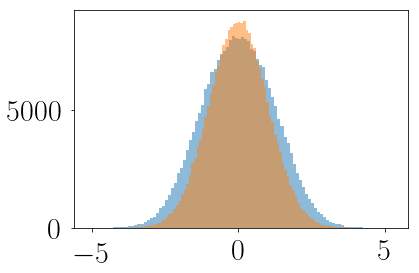

In [223]:
for j, d in enumerate(ds):
    a = np.ones(d)/np.sqrt(d)*np.sqrt(0.5)
    L = 1.0
    m = 1.0 - np.sum(a**2)
    kappa = L/m
    
    print("start simulation for tv error: d = %d, m = %0.2f, L = %0.2f, kappa = %0.2f" %(d, m, L, kappa))

    # define the two directions to measure the error
    dir1 = np.ones(d)/np.sqrt(d)
    dir2 = np.ones(d)/np.sqrt(d)
    dir2[0] *= -1
    print "dir = ", dir1, dir2

    truth = sample_f(nb_exps, d, a) 
    true_counts, true_bins, _ = plt.hist(truth.dot(dir1), bins = nb_bins, alpha = 0.5)
    true_counts2, true_bins2, _ = plt.hist(truth.dot(dir2), bins = nb_bins, alpha = 0.5)
    def error_tv(x_curr):
        curent_counts, _ = np.histogram(x_curr.dot(dir1), bins = true_bins)
        curent_counts2, _ = np.histogram(x_curr.dot(dir2), bins = true_bins2)
        
        e1 = discrete_tv(curent_counts, true_counts)/float(nb_exps)
        e2 = discrete_tv(curent_counts2, true_counts2)/float(nb_exps)

        return np.array([e1, e2])
    
    for truth_iter in range(100):
        truth2 = sample_f(nb_exps, d, a)
        curr_error = error_tv(truth2)
        
        error_lower_tv_max[j, 0] = np.maximum(error_lower_tv_max[j, 0], curr_error[0])
        error_lower_tv_max[j, 1] = np.maximum(error_lower_tv_max[j, 1], curr_error[1])

        error_lower_tv_min[j, 0] = np.minimum(error_lower_tv_min[j, 0], curr_error[0])
        error_lower_tv_min[j, 1] = np.minimum(error_lower_tv_min[j, 1], curr_error[1])
    
    print error_lower_tv_max[j], error_lower_tv_min[j]

    

    # initialization
#     init_sigma = 0.001
#     init_distr = 2+init_sigma*np.random.randn(nb_exps, d)
    init_distr = 1./np.sqrt(2*L)*np.random.randn(nb_exps, d)

    def grad_f_local(x):
        return grad_f(x, a=a)

    def f_local(x):
        return density_f(x, a=a)

    error_ula_all[j], x_ula = mcmc.ula(init_distr, grad_f_local, error_tv, epsilon=1.0, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_ula_02_all[j], x_ula_02 = mcmc.ula(init_distr, grad_f_local, error_tv, epsilon=0.2, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_ula_002_all[j], x_ula_002 = mcmc.ula(init_distr, grad_f_local, error_tv, epsilon=0.1, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_mala_all[j], x_mala = mcmc.mala(init_distr, grad_f_local, f_local, error_tv, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

    error_rwmh_all[j], x_rwmh = mcmc.rwmh(init_distr, f_local, error_tv, kappa=kappa, L=L, nb_iters=nb_iters, nb_exps=nb_exps)

In [311]:
# plot the sum of discrete tv errors on two directions
def plot_tv_run(j=0):
    plt.figure(figsize=(12., 8.))
    markers_on = np.arange(5, nb_iters, 25)
    plt.semilogy(np.arange(nb_iters), error_ula_all[j, :, 0] + error_ula_all[j, :, 1], '*-.', color='orange', alpha = 0.5, markevery=markers_on, markersize=12.,  label='ULA large')
    plt.semilogy(np.arange(nb_iters), error_ula_02_all[j, :, 0] + error_ula_02_all[j, :, 1], 'sr-', alpha = 0.5, markevery=markers_on, markersize=9., label='ULA')
    plt.semilogy(np.arange(nb_iters), error_ula_002_all[j, :, 0] + error_ula_002_all[j, :, 1], '^g--', color='purple', alpha = 0.5, markevery=markers_on, markersize=9., label='ULA small')

#     plt.semilogy(np.arange(nb_iters), error_mala_all[j, :, 0] + error_mala_all[j, :, 1], '*b-.', alpha = 0.5, markevery=markers_on, markersize=12., label='MALA')
#     plt.semilogy(np.arange(nb_iters), error_rwmh_all[j, :, 0] + error_rwmh_all[j, :, 1], '^g--', alpha = 0.5, markevery=markers_on, markersize=9., label='MRW')

    plt.xlabel("Iteration")
    plt.ylabel("Discrete TV error")
     
    plt.ylim(0.02, 1.1)
    plt.legend()

    plt.axhline(error_lower_tv_max[j, 0]+error_lower_tv_max[j, 1], color='k')
    plt.axhline(error_lower_tv_min[j, 0]+error_lower_tv_min[j, 1], color='k')
    
    plt.savefig(save_path+'gaussian_mixture_u1u2_ula_sparseplot.pdf')

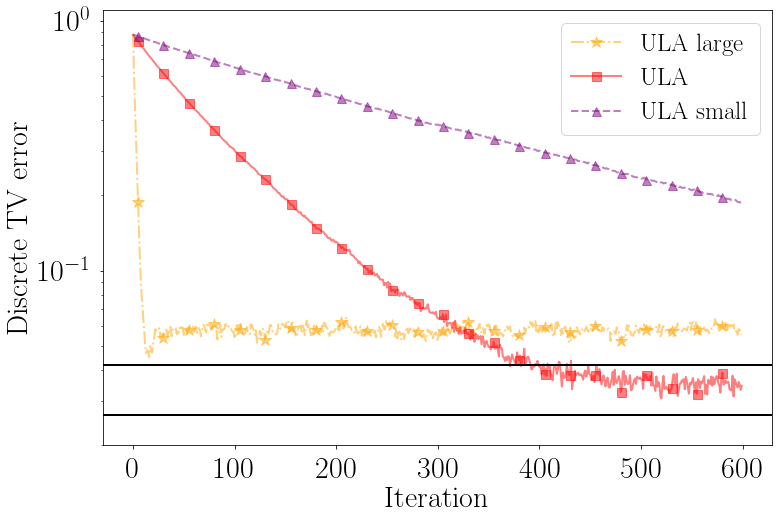

In [312]:
plot_tv_run(0)

In [250]:
label_size = 30

params = {'figure.figsize': (8.0, 6.0),
          'lines.linewidth': 2.,
          'legend.fontsize': 25,
          'axes.labelsize': label_size,
          'xtick.labelsize': label_size,
          'ytick.labelsize': label_size,
          'xtick.major.pad': 8,
          'ytick.major.pad': 8}

plt.rcParams.update(params)